# Milestone Project 1: Food Vision Big
This project is done on colab since the dataset filesize is quite big (5 gb)

## Check the Colab GPU and ensure it is a Tesla T4, in order to use mixed precision training

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-147ae79c-4758-b356-40ae-c699ce4dad94)


In [ ]:
# Import the helper function
# No need if it is already in your folder
!wget https://raw.githubusercontent.com/EngMarchG/TensorFlow-Mastery/master/helper/helperFunctions.py

--2022-05-16 12:09:46--  https://raw.githubusercontent.com/EngMarchG/TensorFlow-Mastery/master/helper/helperFunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13247 (13K) [text/plain]
Saving to: ‘helperFunctions.py’

helperFunctions.py  100%[===================>]  12.94K  --.-KB/s    in 0s      

2022-05-16 12:09:47 (124 MB/s) - ‘helperFunctions.py’ saved [13247/13247]



## Import the helper Module from previous sections

In [ ]:
# Import a few functionalities of the module
# import sys
# sys.path.append("./../helper/")
from helperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys

# Use TensorFlow Datasets to Download Data

In [ ]:
# import TensorFlow Datasets
import tensorflow_datasets as tfds 

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # Checking if the target dataset is in the list

True


In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # Data gets returned as tuple (data, label)
                                             with_info=True) # Downloads ds_info aka meta data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteWIIQG9/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteWIIQG9/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 Data from Tensorflow DataSet

To become one with the data, find:
- Class names
- The shape of input data
The datatype of our input data
- What the labels look like (one-hot encoded or strings)
- Do the labels match up with the image

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class name
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# Create preprocessing Functions for the data
How the data currently is:
- Type: 'uint8' datatyp
- Comprised of different sized tensors
- Unscaled

What do models prefer:
- Data in 'float32' dtype or mixed precision type 'float16 and float32'
- Batch sizes need to be of the same image size
- Scaled images (0 & 1)

Rescaling won't be necessary in this case since EfficientNetBX will be used

In [ ]:
from helperFunctions import preprocessed_img_sparse

## Prepare batches 
Data input pipelines are recommended to run really fast.

Extra resources: www.tensorflow.org/guide

In [ ]:
import tensorflow as tf
tf.function(jit_compile=True)

# Map preprocessing function to training and (parallelize)
train_data = train_data.map(map_func=preprocessed_img_sparse, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE) # Stores data in memory for faster batching

# Map preprocessing function to test data
test_data = test_data.map(preprocessed_img_sparse, num_parallel_calls=tf.data.AUTOTUNE).batch(128).prefetch(tf.data.AUTOTUNE) # .cache if needed

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>)

Maps the preprocessing function ('preprocess_img') across the training dataset, then shuffle a number of elements and batch them together. Finally, prepare new patches (prefetch), while the model is looking through (finding patterns) in the current batch.

## Create modelling callbacks

Create a couple of callbacks to help out while the model trains
- TensorBoard Callback to log training results (so it can be visalized later if needed)
- ModelCheckPoint callback to save the model's progress after feature extraction

In [ ]:
# Create a tensorboard callback (premade function will be imported)
from helperFunctions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc", # others like val_loss
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # 0 doesn't print 1 prints 2 prints more stuff


## Setup mixed precision training
To understand the process read the following link: [Precision training](www.tensorflow.org/guide/mixed_precision)

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Set global policy to mixed precision
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

## Building the feature extracting model

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

In [ ]:
# First rebuild the mode with data augmentation
from tensorflow.keras import Sequential
data_augmentation = Sequential([
                                layers.RandomFlip("horizontal_and_vertical"),
                                layers.RandomZoom(0.2),
                                layers.RandomWidth(0.2),
                                layers.RandomHeight(0.2),
                                layers.RandomRotation(0.35),
                                layers.RandomContrast(0.2)
], name="data_agumentation")

In [ ]:
# # Create base model
# input_shape = (224, 224, 3)
# base_model_augmented = tf.keras.applications.EfficientNetV2B0(include_top=False)

In [ ]:
# # Store the fully connected layers
# fc1 = base_model_augmented.layers[-3]
# fc2 = base_model_augmented.layers[-2]
# predictions = base_model_augmented.layers[-1]

# # Create the dropout layers
# dropout1 = layers.Dropout(0.35)
# dropout2 = layers.Dropout(0.35)

# # Reconnect the layers
# x = dropout1(fc1.output)
# x = fc2(x)
# x = dropout2(x)
# predictors = predictions(x)

# # Create a new model
# base_model_augmented = tf.keras.Model(base_model_augmented.input, predictors)
# base_model_augmented.trainable = False

In [ ]:
# # Create Functional model
# inputs = layers.Input(shape=input_shape, name="input_layer")
# # x = preprocessing.Rescaling(1/255)(x)  # if rescaling was necessary
# x = data_augmentation(inputs)
# x = base_model_augmented(x, training=False)

# # Rebuild the top layer
# x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x) 
# x = layers.Dense(1010, activation=tf.keras.layers.LeakyReLU(0.3))(x)
# x = layers.BatchNormalization(name="top_added_bn")(x)
# # Added a dropout layer
# x = layers.Dense(len(class_names))(x)
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# # Only change is the activation outside to pass types
# base_model_augmented = tf.keras.Model(inputs, outputs)

In [ ]:
# # Create base model
# input_shape = (224, 224, 3)
# base_model_augmented = tf.keras.applications.EfficientNetV2B0(include_top=False)
# base_model_augmented.trainable = False

# # Create Functional model
# inputs = layers.Input(shape=input_shape, name="input_layer")
# # x = preprocessing.Rescaling(1/255)(x)  # if rescaling was necessary
# x = data_augmentation(inputs)
# x = base_model_augmented(x, training=False)

# x = layers.GlobalMaxPooling2D(keepdims=True)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Conv2D(640, 3, padding="same")(x)
# x = layers.GlobalMaxPool2D()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(len(class_names))(x)
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# # Only change is the activation outside to pass types
# base_model_augmented = tf.keras.Model(inputs, outputs)

In [ ]:
# Create base model
input_shape = (224, 224, 3)
base_model_augmented = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model_augmented.trainable = False

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = preprocessing.Rescaling(1/255)(x)  # if rescaling was necessary
x = data_augmentation(inputs)
x = base_model_augmented(x, training=False)

x = layers.Dropout(0.2)(x)
x = layers.GlobalMaxPooling2D(keepdims=True)(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
x = layers.GlobalMaxPool2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# Only change is the activation outside to pass types
base_model_augmented = tf.keras.Model(inputs, outputs)

24289280/24274472 [==============================] - 0s 0us/step


In [ ]:
# Call back the function early if there is no improvement or overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
# Compile the model
base_model_augmented.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adamax(),
              metrics=["accuracy"])

# Fit the model till called back
initial_epochs = 25
history_1_101_foods_all_augmented = base_model_augmented.fit(train_data,
                                                            epochs=initial_epochs,
                                                            steps_per_epoch=len(train_data),
                                                            validation_data=test_data,
                                                            validation_steps=int(0.15*len(test_data)),
                                                            callbacks=[create_tensorboard_callback(
                                                                "training_log_aug",
                                                                 "efficientnetV2b0_101_classes_all_data_augmented_dropout"), 
                                                                 model_checkpoint, 
                                                                 callback])

Saving TensorBoard log files to: training_log_aug/efficientnetV2b0_101_classes_all_data_augmented_dropout/20220516-121728
Epoch 1/25
592/592 [==============================] - ETA: 0s - loss: 3.4122 - accuracy: 0.2290WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 213s 321ms/step - loss: 3.4122 - accuracy: 0.2290 - val_loss: 2.2854 - val_accuracy: 0.4281
Epoch 2/25
592/592 [==============================] - ETA: 0s - loss: 2.6144 - accuracy: 0.3720WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 179s 299ms/step - loss: 2.6144 - accuracy: 0.3720 - val_loss: 1.9316 - val_accuracy: 0.5048
Epoch 3/25
592/592 [==============================] - ETA: 0s - loss: 2.3794 - accuracy: 0.4223WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 165s 274ms/step - loss: 2.3794 - accuracy: 0.4223 - val_loss: 1.7769 - val_accuracy: 0.5396
Epoch 4/25
592/592 [==============================] - ETA: 0s - loss: 2.2588 - accuracy: 0.4469WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 156s 260ms/step - loss: 2.2588 - accuracy: 0.4469 - val_loss: 1.6884 - val_accuracy: 0.5617
Epoch 5/25
592/592 [==============================] - ETA: 0s - loss: 2.1840 - accuracy: 0.4645WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 154s 256ms/step - loss: 2.1840 - accuracy: 0.4645 - val_loss: 1.6194 - val_accuracy: 0.5776
Epoch 6/25
592/592 [==============================] - ETA: 0s - loss: 2.1147 - accuracy: 0.4796WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 155s 259ms/step - loss: 2.1147 - accuracy: 0.4796 - val_loss: 1.5621 - val_accuracy: 0.5929
Epoch 7/25
592/592 [==============================] - ETA: 0s - loss: 2.0871 - accuracy: 0.4846WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 149s 249ms/step - loss: 2.0871 - accuracy: 0.4846 - val_loss: 1.5412 - val_accuracy: 0.5959
Epoch 8/25
592/592 [==============================] - ETA: 0s - loss: 2.0496 - accuracy: 0.4922WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 152s 254ms/step - loss: 2.0496 - accuracy: 0.4922 - val_loss: 1.5242 - val_accuracy: 0.6032
Epoch 9/25
592/592 [==============================] - ETA: 0s - loss: 2.0289 - accuracy: 0.4987WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 147s 246ms/step - loss: 2.0289 - accuracy: 0.4987 - val_loss: 1.4970 - val_accuracy: 0.6072
Epoch 10/25
592/592 [==============================] - ETA: 0s - loss: 2.0035 - accuracy: 0.5008WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 151s 251ms/step - loss: 2.0035 - accuracy: 0.5008 - val_loss: 1.4749 - val_accuracy: 0.6107
Epoch 11/25
592/592 [==============================] - ETA: 0s - loss: 1.9844 - accuracy: 0.5056WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 146s 243ms/step - loss: 1.9844 - accuracy: 0.5056 - val_loss: 1.4699 - val_accuracy: 0.6113
Epoch 12/25
592/592 [==============================] - ETA: 0s - loss: 1.9706 - accuracy: 0.5093WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 147s 245ms/step - loss: 1.9706 - accuracy: 0.5093 - val_loss: 1.4590 - val_accuracy: 0.6180
Epoch 13/25
592/592 [==============================] - ETA: 0s - loss: 1.9621 - accuracy: 0.5130WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 146s 243ms/step - loss: 1.9621 - accuracy: 0.5130 - val_loss: 1.4494 - val_accuracy: 0.6215
Epoch 14/25
592/592 [==============================] - ETA: 0s - loss: 1.9524 - accuracy: 0.5146WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 148s 248ms/step - loss: 1.9524 - accuracy: 0.5146 - val_loss: 1.4385 - val_accuracy: 0.6210
Epoch 15/25
592/592 [==============================] - ETA: 0s - loss: 1.9348 - accuracy: 0.5189WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 144s 241ms/step - loss: 1.9348 - accuracy: 0.5189 - val_loss: 1.4403 - val_accuracy: 0.6188
Epoch 16/25
592/592 [==============================] - ETA: 0s - loss: 1.9294 - accuracy: 0.5173WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 155s 259ms/step - loss: 1.9294 - accuracy: 0.5173 - val_loss: 1.4251 - val_accuracy: 0.6280
Epoch 17/25
592/592 [==============================] - ETA: 0s - loss: 1.9220 - accuracy: 0.5206WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 149s 249ms/step - loss: 1.9220 - accuracy: 0.5206 - val_loss: 1.4362 - val_accuracy: 0.6247
Epoch 18/25
592/592 [==============================] - ETA: 0s - loss: 1.9251 - accuracy: 0.5222WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 161s 269ms/step - loss: 1.9251 - accuracy: 0.5222 - val_loss: 1.4125 - val_accuracy: 0.6280
Epoch 19/25
592/592 [==============================] - ETA: 0s - loss: 1.9156 - accuracy: 0.5199WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 150s 251ms/step - loss: 1.9156 - accuracy: 0.5199 - val_loss: 1.4135 - val_accuracy: 0.6301
Epoch 20/25
592/592 [==============================] - ETA: 0s - loss: 1.9109 - accuracy: 0.5233WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 148s 247ms/step - loss: 1.9109 - accuracy: 0.5233 - val_loss: 1.4112 - val_accuracy: 0.6304
Epoch 21/25
592/592 [==============================] - ETA: 0s - loss: 1.9024 - accuracy: 0.5241WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 149s 248ms/step - loss: 1.9024 - accuracy: 0.5241 - val_loss: 1.4042 - val_accuracy: 0.6307
Epoch 22/25
592/592 [==============================] - ETA: 0s - loss: 1.9164 - accuracy: 0.5205WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 149s 249ms/step - loss: 1.9164 - accuracy: 0.5205 - val_loss: 1.4019 - val_accuracy: 0.6298
Epoch 23/25
592/592 [==============================] - ETA: 0s - loss: 1.9058 - accuracy: 0.5240WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 145s 242ms/step - loss: 1.9058 - accuracy: 0.5240 - val_loss: 1.4053 - val_accuracy: 0.6325
Epoch 24/25
592/592 [==============================] - ETA: 0s - loss: 1.8992 - accuracy: 0.5243WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 147s 246ms/step - loss: 1.8992 - accuracy: 0.5243 - val_loss: 1.3868 - val_accuracy: 0.6371
Epoch 25/25
592/592 [==============================] - ETA: 0s - loss: 1.8979 - accuracy: 0.5268WARNING:tensorflow:Can save best model only with val_acc available, skipping.


592/592 [==============================] - 148s 247ms/step - loss: 1.8979 - accuracy: 0.5268 - val_loss: 1.4022 - val_accuracy: 0.6331


In [ ]:
evaluated_base_aug = base_model_augmented.evaluate(test_data)
evaluated_base_aug

790/790 [==============================] - 49s 62ms/step - loss: 1.2547 - accuracy: 0.6642


[1.2546886205673218, 0.6641584038734436]

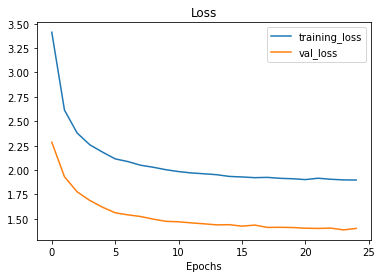

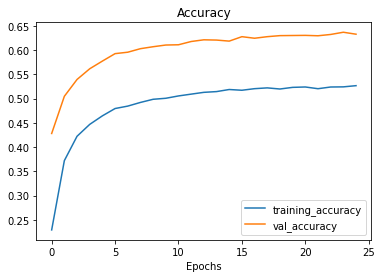

In [ ]:
plot_loss_curves(history_1_101_foods_all_augmented)

Great looking curves. Time to fine tune the model

## Fine-Tuning the model

In [ ]:
# Save the new augmented model 
base_model_augmented.save("model_101_foods_augmented_dropout_model_v2_adamax")

INFO:tensorflow:Assets written to: model_101_foods_augmented_dropout_model_v2_adamax/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_dropout_model_v2_adamax/assets


In [ ]:
# Load the augmented model
base_model_augmented = tf.keras.models.load_model("model_101_foods_augmented_dropout_model_v2_adamax")

In [ ]:
del history_3_101_foods_all_augmented
import gc
gc.collect()

118679

In [ ]:
# Unfreeze a block
base_model_augmented.trainable = True

for layer in base_model_augmented.layers[2].layers[:-58]:
  layer.trainable = False
for layer in base_model_augmented.layers[2].layers[-28:]:
  layer.trainable = False

In [ ]:
for num, layer in enumerate(base_model_augmented.layers[2].layers):
  print(num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_add False
20 block3a_expand_conv False
21 block3a_expand_bn False
22 block3a_expand_activation False
23 block3a_project_conv False
24 block3a_project_bn False
25 block3b_expand_conv False
26 block3b_expand_bn False
27 block3b_expand_activation False
28 block3b_project_conv False
29 block3b_project_bn False
30 block3b_add False
31 block4a_expand_conv False
32 block4a_expand_bn False
33 block4a_expand_activation False
34 block4a_dwconv2 False
35 block4a_bn False
36 block4a_activation 

In [ ]:
# Call back the function early if there is no improvement or overfitting
# For adam
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Fine-tune for another 3 epochs or till called back
fine_tune_epochs = initial_epochs + 15

# Recompile the model
base_model_augmented.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002),
                metrics=["accuracy"])

# Fit the model
history_2_101_foods_all_augmented = base_model_augmented.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetV2b0_101_classes_all_data_augmented_6030l_adamax"), 
                                                             callback],
                                                             initial_epoch=history_1_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetV2b0_101_classes_all_data_augmented_6030l_adamax/20220516-133441
Epoch 25/40
592/592 [==============================] - 169s 264ms/step - loss: 1.6063 - accuracy: 0.5905 - val_loss: 1.0937 - val_accuracy: 0.7134
Epoch 26/40
592/592 [==============================] - 152s 254ms/step - loss: 1.4206 - accuracy: 0.6302 - val_loss: 0.9952 - val_accuracy: 0.7314
Epoch 27/40
592/592 [==============================] - 155s 258ms/step - loss: 1.3193 - accuracy: 0.6532 - val_loss: 0.9477 - val_accuracy: 0.7363
Epoch 28/40
592/592 [==============================] - 150s 251ms/step - loss: 1.2293 - accuracy: 0.6716 - val_loss: 0.9332 - val_accuracy: 0.7422
Epoch 29/40
592/592 [==============================] - 154s 257ms/step - loss: 1.1511 - accuracy: 0.6908 - val_loss: 0.9272 - val_accuracy: 0.7438
Epoch 30/40
592/592 [==============================] - 149s 249ms/step - loss: 1.0960 - accuracy: 0.7049 - val_loss: 0.9281 - val_accuracy

In [ ]:
# Evaluate the augmented and fine-tuned model over the whole test set
base_model_augmented.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 1.0812 - accuracy: 0.7062


[1.0812370777130127, 0.7061781883239746]

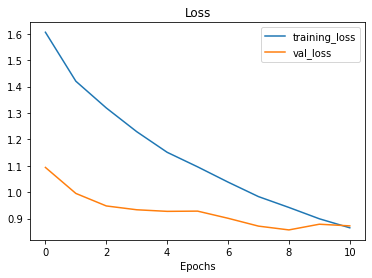

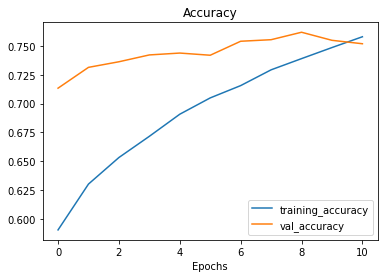

In [ ]:
# Plot the loss curves of the new history
# The model trend appears to be much better than last time!
plot_loss_curves(history_2_101_foods_all_augmented)

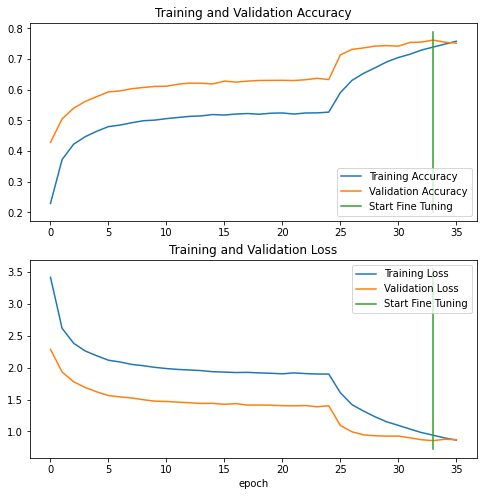

In [ ]:
compare_historys(history_1_101_foods_all_augmented, history_2_101_foods_all_augmented, initial_epochs=history_2_101_foods_all_augmented.epoch[-1])

Comparing the history of the new model with the old non-trainable one, it can be seen that the model stops improving as much at around 5 epochs.

In [ ]:
base_model_augmented.save("model_101_foods_augmented_dropout_5828l_v2_adamax")

INFO:tensorflow:Assets written to: model_101_foods_augmented_dropout_5828l_v2_adamax/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_dropout_5828l_v2_adamax/assets


## Unfreeze a different block

In [ ]:
model_3 = tf.keras.models.load_model("model_101_foods_augmented_dropout_5828l_v2_adamax")
# model_3 = base_model_augmented

In [ ]:
model_3.load_weights("model_101_foods_augmented_model_fine_tuned_dropout_5828l_v2_admax")

In [ ]:
# Unfreeze another block
model_3.trainable = True

for layer in model_3.layers[2].layers[:-28]:
  layer.trainable = False
for layer in model_3.layers[2].layers[-13:]:
  layer.trainable = False

In [ ]:
# Fine-tune till called back
fine_tune_epochs = history_2_101_foods_all_augmented.epoch[-1] + 15

# Recompile the model
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), # good was 0.00025
                metrics=["accuracy"])

# Fit the model
history_3_101_foods_all_augmented = model_3.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_2813l_adamax"), 
                                                                 callback],
                                                             initial_epoch=history_2_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_2813l_adamax/20220516-141316
Epoch 35/49
592/592 [==============================] - 157s 247ms/step - loss: 0.8389 - accuracy: 0.7618 - val_loss: 0.8150 - val_accuracy: 0.7726
Epoch 36/49
592/592 [==============================] - 150s 251ms/step - loss: 0.8045 - accuracy: 0.7721 - val_loss: 0.8275 - val_accuracy: 0.7713
Epoch 37/49
592/592 [==============================] - 171s 287ms/step - loss: 0.7895 - accuracy: 0.7759 - val_loss: 0.8276 - val_accuracy: 0.7678


In [ ]:
model_3.evaluate(test_data)

198/198 [==============================] - 42s 211ms/step - loss: 0.8206 - accuracy: 0.7733


[0.8206276893615723, 0.7733465433120728]

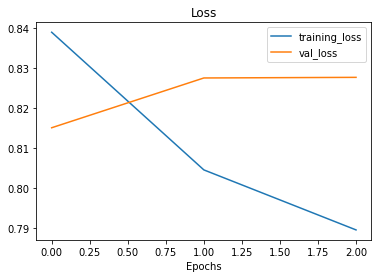

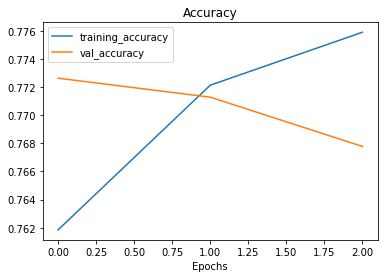

In [ ]:
# The last epochs seems to barely make a dent but the over all trend apepear 
# to be good
plot_loss_curves(history_3_101_foods_all_augmented)

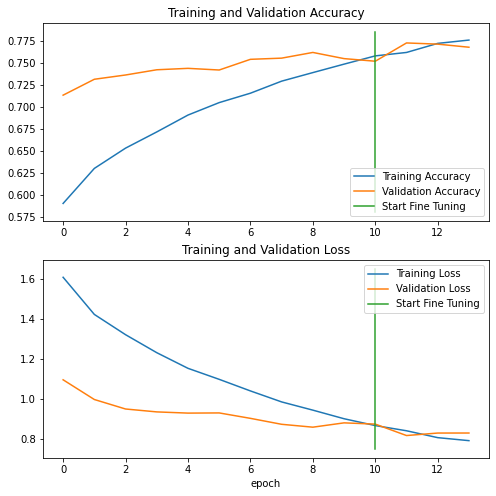

In [ ]:
compare_historys(history_2_101_foods_all_augmented,history_3_101_foods_all_augmented, 
                 initial_epochs=11)

In [ ]:
# Save the model
model_3.save("model_101_foods_augmented_dropout_2813l_v2_adamax")

INFO:tensorflow:Assets written to: model_101_foods_augmented_dropout_2813l_v2_adamax/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_dropout_2813l_v2_adamax/assets


In [ ]:
model_3.load_weights("model_101_foods_augmented_dropout_2813l_v2_adamax")

In [ ]:
# Colab commands to download the model
!zip -r /content/model_101_foods_augmented_dropout_2813l_v2_adamax.zip /content/model_101_foods_augmented_dropout_2813l_v2_adamax
!zip -r /content/model_101_foods_augmented_dropout_5828l_v2_adamax.zip /content/model_101_foods_augmented_dropout_5828l_v2_adamax

# Download the file 
from google.colab import files
files.download("/content/model_101_foods_augmented_dropout_2813l_v2_adamax.zip")
files.download("/content/model_101_foods_augmented_dropout_5828l_v2_adamax.zip")

  adding: content/model_101_foods_augmented_dropout_2813l_v2_adamax/ (stored 0%)
  adding: content/model_101_foods_augmented_dropout_2813l_v2_adamax/saved_model.pb (deflated 92%)
  adding: content/model_101_foods_augmented_dropout_2813l_v2_adamax/assets/ (stored 0%)
  adding: content/model_101_foods_augmented_dropout_2813l_v2_adamax/variables/ (stored 0%)
  adding: content/model_101_foods_augmented_dropout_2813l_v2_adamax/variables/variables.index (deflated 75%)
  adding: content/model_101_foods_augmented_dropout_2813l_v2_adamax/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_101_foods_augmented_dropout_2813l_v2_adamax/keras_metadata.pb (deflated 96%)
  adding: content/model_101_foods_augmented_dropout_5828l_v2_adamax/ (stored 0%)
  adding: content/model_101_foods_augmented_dropout_5828l_v2_adamax/saved_model.pb (deflated 91%)
  adding: content/model_101_foods_augmented_dropout_5828l_v2_adamax/assets/ (stored 0%)
  adding: content/model_101_foods_augmented

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Clear up ram for colab 
import gc
del history_1_101_foods_all_augmented
del history_2_101_foods_all_augmented
gc.collect()

769

In [ ]:
# # Use for adam to balance out training

# class_weights = [1.05 if i<15 and i>1 or i>60 and i<72 else 1. for i in range(0,101)]
# tf_weights = {}
# for i in range(101):
#   tf_weights[i] = class_weights[i]

In [ ]:
# Final model with 5 layers and till called back
model_4 = tf.keras.models.load_model("model_101_foods_augmented_dropout_2813l_v2_adamax")
# model_4 = model_3

In [ ]:
# # Unfreeze the last 60-30 layers layers to learn fine details
# model_4.trainable = True

# for layer in model_4.layers[2].layers[:-58]:
#   layer.trainable = False

In [ ]:
# Unfreeze a few blocks and lower learning rate
model_4.trainable = True

for layer in model_4.layers[2].layers[:-114]:
  layer.trainable = False
# for layer in model_5_aug_fine_tuned_dropout.layers[2].layers[-75:]:
#   layer.trainable = False

In [ ]:
for layer in model_4.layers:
  print(layer.trainable, layer.name)

True input_layer
True data_agumentation
False model_16
False global_average_pooling_2D
False top_added_bn
False dense_17
False dense_18
False softmax_float32


In [ ]:
for i, layer in enumerate(model_4.layers[2].layers):
  print(i, layer.trainable, layer.name)

0 False input_1
1 False rescaling
2 False normalization
3 False stem_conv
4 False stem_bn
5 False stem_activation
6 False block1a_project_conv
7 False block1a_project_bn
8 False block1a_project_activation
9 False block2a_expand_conv
10 False block2a_expand_bn
11 False block2a_expand_activation
12 False block2a_project_conv
13 False block2a_project_bn
14 False block2b_expand_conv
15 False block2b_expand_bn
16 False block2b_expand_activation
17 False block2b_project_conv
18 False block2b_project_bn
19 False block2b_add
20 False block3a_expand_conv
21 False block3a_expand_bn
22 False block3a_expand_activation
23 False block3a_project_conv
24 False block3a_project_bn
25 False block3b_expand_conv
26 False block3b_expand_bn
27 False block3b_expand_activation
28 False block3b_project_conv
29 False block3b_project_bn
30 False block3b_add
31 False block4a_expand_conv
32 False block4a_expand_bn
33 False block4a_expand_activation
34 False block4a_dwconv2
35 False block4a_bn
36 False block4a_activ

In [ ]:
# Fine-tune for another 4 epochs (or till called back)
fine_tune_epochs = history_3_101_foods_all_augmented.epoch[-1] + 20

# Recompile the model
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001), 
                metrics=["accuracy"])

# Fit the model
history_4_101_foods_all_augmented = model_4.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_114end_adamax"
                                                             ),
                                                             callback],
                                                             initial_epoch=history_3_101_foods_all_augmented.epoch[-1])
                                                             # class_weight=tf_weights)


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_13l_adamax/20220516-153139
Epoch 37/56
592/592 [==============================] - 179s 280ms/step - loss: 0.7798 - accuracy: 0.7799 - val_loss: 0.8039 - val_accuracy: 0.7742
Epoch 38/56
592/592 [==============================] - 165s 275ms/step - loss: 0.7342 - accuracy: 0.7948 - val_loss: 0.7987 - val_accuracy: 0.7794
Epoch 39/56
592/592 [==============================] - 169s 281ms/step - loss: 0.7047 - accuracy: 0.8006 - val_loss: 0.7880 - val_accuracy: 0.7786
Epoch 40/56
592/592 [==============================] - 166s 276ms/step - loss: 0.6782 - accuracy: 0.8066 - val_loss: 0.7960 - val_accuracy: 0.7812
Epoch 41/56
592/592 [==============================] - 167s 278ms/step - loss: 0.6667 - accuracy: 0.8094 - val_loss: 0.7719 - val_accuracy: 0.7896
Epoch 42/56
592/592 [==============================] - 177s 294ms/step - loss: 0.6445 - accuracy: 0.8153 - val_loss: 0.7861 - val_accuracy: 0.

In [ ]:
model_4.save("model_101_foods_augmented_dropout_114end_v2_adamax")

In [ ]:
# Colab commands to download the model
!zip -r /content/model_101_foods_augmented_dropout_114end_v2_adamax.zip /content/model_101_foods_augmented_dropout_114end_v2_adamax

# Download the file 
from google.colab import files
files.download("/content/model_101_foods_augmented_dropout_114end_v2_adamax.zip")

  adding: content/model_101_foods_augmented_dropout_114end_v2_adamax/ (stored 0%)
  adding: content/model_101_foods_augmented_dropout_114end_v2_adamax/saved_model.pb (deflated 91%)
  adding: content/model_101_foods_augmented_dropout_114end_v2_adamax/assets/ (stored 0%)
  adding: content/model_101_foods_augmented_dropout_114end_v2_adamax/variables/ (stored 0%)
  adding: content/model_101_foods_augmented_dropout_114end_v2_adamax/variables/variables.index (deflated 77%)
  adding: content/model_101_foods_augmented_dropout_114end_v2_adamax/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/model_101_foods_augmented_dropout_114end_v2_adamax/keras_metadata.pb (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gc.collect()

673384

In [ ]:
model_4.load_weights("model_101_foods_augmented_dropout_114end_v2_adamax")

In [ ]:
model_5 = model_4

In [ ]:
model_5.trainable = True

for layer in model_4.layers[2].layers[:103]:
  layer.trainable = False

In [ ]:
# Fine-tune for another 4 epochs (or till called back)
fine_tune_epochs = history_4_101_foods_all_augmented.epoch[-1] + 15

# Recompile the model
model_5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0005),
                metrics=["accuracy"])

# Fit the model
history_5_101_foods_all_augmented = model_5.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned_103endLayers"
                                                             ),
                                                             callback],
                                                             initial_epoch=history_4_101_foods_all_augmented.epoch[-1])
                                                             #class_weight=tf_weights)


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers/20220516-161911
Epoch 43/57
592/592 [==============================] - 192s 301ms/step - loss: 0.7403 - accuracy: 0.7895 - val_loss: 0.8217 - val_accuracy: 0.7729
Epoch 44/57
592/592 [==============================] - 176s 293ms/step - loss: 0.6483 - accuracy: 0.8143 - val_loss: 0.8257 - val_accuracy: 0.7697
Epoch 45/57
592/592 [==============================] - 172s 286ms/step - loss: 0.5999 - accuracy: 0.8260 - val_loss: 0.7264 - val_accuracy: 0.7969
Epoch 46/57
592/592 [==============================] - 177s 295ms/step - loss: 0.5509 - accuracy: 0.8395 - val_loss: 0.7942 - val_accuracy: 0.7812
Epoch 47/57
592/592 [==============================] - 176s 293ms/step - loss: 0.5018 - accuracy: 0.8523 - val_loss: 0.8104 - val_accuracy: 0.7718


In [ ]:
# Evaluate the performance of model_4 and model_5 since validation only looks at 15% of the test data
model_4.evaluate(test_data), model_5.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 0.9363 - accuracy: 0.7516


([0.9362660050392151, 0.7516039609909058],
 [0.936265766620636, 0.7516039609909058])

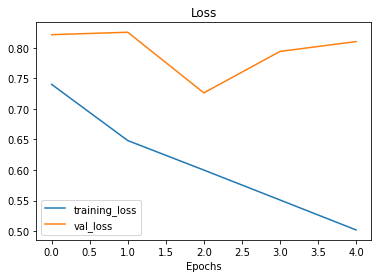

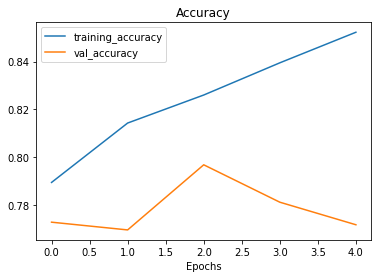

In [ ]:
plot_loss_curves(history_5_101_foods_all_augmented)

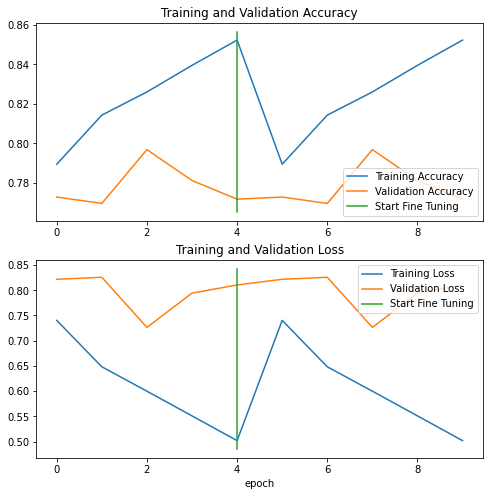

In [ ]:
compare_historys(history_5_101_foods_all_augmented,history_5_101_foods_all_augmented, initial_epochs=5)

In [ ]:
model_5.save("model_101_foods_augmented_dropout_103end_v2_adamax_best")
# Colab commands to download the model
!zip -r /content/model_101_foods_augmented_dropout_103end_v2_adamax_best.zip /content/model_101_foods_augmented_dropout_103end_v2_adamax_best
!zip -r /content/training_log_aug.zip /content/training_log_aug

# Download the file 
from google.colab import files
files.download("/content/model_101_foods_augmented_dropout_103end_v2_adamax_best.zip")
files.download("/content/training_log_aug.zip")

In [ ]:
model_6 = tf.keras.models.load_model("model_101_foods_augmented_dropout_103end_v2_adamax_best")

In [93]:
gc.collect()

5762

In [94]:
# perform the experiment before once again 
# Unfreeze the last 20 layers
model_6.trainable = True
for layer in model_6.layers[2].layers[:-201]:
  layer.trainable = False
for layer in model_6.layers[2].layers[-181:]:
  layer.trainable = False

In [95]:
for i, layer in enumerate(model_6.layers[2].layers):
  print(i, layer.trainable, layer.name)

0 False input_1
1 False rescaling
2 False normalization
3 False stem_conv
4 False stem_bn
5 False stem_activation
6 False block1a_project_conv
7 False block1a_project_bn
8 False block1a_project_activation
9 False block2a_expand_conv
10 False block2a_expand_bn
11 False block2a_expand_activation
12 False block2a_project_conv
13 False block2a_project_bn
14 False block2b_expand_conv
15 False block2b_expand_bn
16 False block2b_expand_activation
17 False block2b_project_conv
18 False block2b_project_bn
19 False block2b_add
20 False block3a_expand_conv
21 False block3a_expand_bn
22 False block3a_expand_activation
23 False block3a_project_conv
24 False block3a_project_bn
25 False block3b_expand_conv
26 False block3b_expand_bn
27 False block3b_expand_activation
28 False block3b_project_conv
29 False block3b_project_bn
30 False block3b_add
31 False block4a_expand_conv
32 False block4a_expand_bn
33 False block4a_expand_activation
34 False block4a_dwconv2
35 False block4a_bn
36 False block4a_activ

In [ ]:
# class_weights = [1.15 if i>44 and i<60 or i>69 and i<80 else 1. for i in range(0,101)]
# tf_weights = {}
# for i in range(101):
#   tf_weights[i] = class_weights[i]

In [96]:
# Recompile the model
model_6.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001),
                metrics=["accuracy"])

# Fit the model
history_6 = model_6.fit(train_data,
                        epochs=history_5_101_foods_all_augmented.epoch[-1]+10,
                        validation_data=test_data,
                        validation_steps=int(0.15*len(test_data)),
                        callbacks=[create_tensorboard_callback(
                            "training_log_aug",
                            "efficientnetb0_101_classes_all_data_augmented_fine_tuned_210181endLayers"
                        ),
                        callback],
                        initial_epoch=history_5_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_210181endLayers/20220516-165809
Epoch 47/56
592/592 [==============================] - 186s 295ms/step - loss: 0.4637 - accuracy: 0.8652 - val_loss: 0.7649 - val_accuracy: 0.7899
Epoch 48/56
592/592 [==============================] - 174s 290ms/step - loss: 0.4568 - accuracy: 0.8683 - val_loss: 0.7703 - val_accuracy: 0.7899
Epoch 49/56
592/592 [==============================] - 173s 288ms/step - loss: 0.4581 - accuracy: 0.8671 - val_loss: 0.7648 - val_accuracy: 0.7915
Epoch 50/56
592/592 [==============================] - 174s 290ms/step - loss: 0.4576 - accuracy: 0.8669 - val_loss: 0.7637 - val_accuracy: 0.7891
Epoch 51/56
 45/592 [=>............................] - ETA: 2:35 - loss: 0.4611 - accuracy: 0.8651

KeyboardInterrupt: ignored

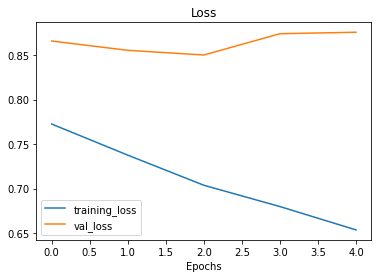

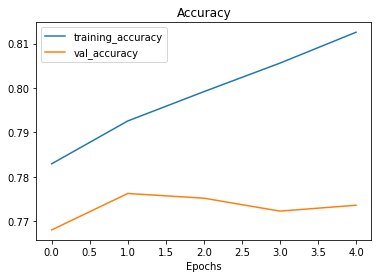

In [ ]:
plot_loss_curves(history_5_101_foods_all_augmented)

In [ ]:
# perform the experiment before once again 
# Unfreeze the last 20 layers
model_6.trainable = True
for layer in model_6.layers[2].layers[:20]:
  layer.trainable = False
for layer in model_6.layers[2].layers[44:]:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(model_5_aug_fine_tuned_dropout.layers[2].layers):
  print(i, layer.trainable, layer.name)

0 False input_9
1 False rescaling_8
2 False normalization_8
3 False stem_conv
4 False stem_bn
5 False stem_activation
6 False block1a_project_conv
7 False block1a_project_bn
8 False block1a_project_activation
9 False block2a_expand_conv
10 False block2a_expand_bn
11 False block2a_expand_activation
12 False block2a_project_conv
13 False block2a_project_bn
14 False block2b_expand_conv
15 False block2b_expand_bn
16 False block2b_expand_activation
17 False block2b_project_conv
18 False block2b_project_bn
19 False block2b_add
20 True block3a_expand_conv
21 True block3a_expand_bn
22 True block3a_expand_activation
23 True block3a_project_conv
24 True block3a_project_bn
25 True block3b_expand_conv
26 True block3b_expand_bn
27 True block3b_expand_activation
28 True block3b_project_conv
29 True block3b_project_bn
30 True block3b_add
31 True block4a_expand_conv
32 True block4a_expand_bn
33 True block4a_expand_activation
34 True block4a_dwconv2
35 True block4a_bn
36 True block4a_activation
37 True

In [ ]:
# Recompile the model
model_6.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Fit the model
history_6 = model_6.fit(train_data,
                        epochs=history_5_101_foods_all_augmented.epoch[-1]+10,
                        validation_data=test_data,
                        validation_steps=int(0.15*len(test_data)),
                        callbacks=[create_tensorboard_callback(
                            "training_log_aug",
                            "efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers"
                        ),
                        callback],
                        initial_epoch=history_5_101_foods_all_augmented.epoch[-1]-3)


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers/20220515-172148
Epoch 32/44
2368/2368 [==============================] - 263s 107ms/step - loss: 0.5992 - accuracy: 0.8284 - val_loss: 0.8225 - val_accuracy: 0.7815
Epoch 33/44
2368/2368 [==============================] - 226s 95ms/step - loss: 0.5904 - accuracy: 0.8292 - val_loss: 0.8237 - val_accuracy: 0.7852
Epoch 34/44
 100/2368 [>.............................] - ETA: 3:33 - loss: 0.6059 - accuracy: 0.8216

KeyboardInterrupt: ignored

In [ ]:
# Save the model
model_6.save("model_101_foods_augmented_model_4471l_v2")

# Colab commands to download the model
!zip -r /content/model_101_foods_augmented_model_4471l_v2.zip /content/model_101_foods_augmented_model_4471l_v2
!zip -r /content/training_log_aug.zip /content/training_log_aug

INFO:tensorflow:Assets written to: model_101_foods_augmented_model_4471l_v2/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_4471l_v2/assets


  adding: content/model_101_foods_augmented_model_4471l_v2/ (stored 0%)
  adding: content/model_101_foods_augmented_model_4471l_v2/saved_model.pb (deflated 92%)
  adding: content/model_101_foods_augmented_model_4471l_v2/assets/ (stored 0%)
  adding: content/model_101_foods_augmented_model_4471l_v2/variables/ (stored 0%)
  adding: content/model_101_foods_augmented_model_4471l_v2/variables/variables.index (deflated 75%)
  adding: content/model_101_foods_augmented_model_4471l_v2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_101_foods_augmented_model_4471l_v2/keras_metadata.pb (deflated 96%)
  adding: content/training_log_aug/ (stored 0%)
  adding: content/training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers/ (stored 0%)
  adding: content/training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers/20220515-155948/ (stored 0%)
  adding: content/training_log_aug/efficientnetb0_101_classes_all_data_augmented_

In [ ]:
# Download the file 
from google.colab import files
files.download("/content/model_101_foods_augmented_model_4471l_v2.zip")
files.download("/content/training_log_aug.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Upload the logs on tensorboard and visualize the progress

In [23]:
!tensorboard dev upload --logdir /content/training_log_aug \
--name "Transfer Learning Experiment with 101 Food Types" \
--description "Predicting 101 Food types Using EfficientNetV2B0 with data augmentation and fine-tuning" \
--one_shot 


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/PLLzJBXjRXOGHB2PtG1L2Q/

[2022-05-17T00:42:20] Started scanning logdir.
Data upload starting...
Uploading binary object (1.1 MB)...
Uploading binary object (1.1 MB)...
Uploading binary object (1.2 MB)...
Uploading binary object (1.3 MB)...
Uploading binary object (1.1 MB)...
Uploading binary object (1.1 MB)...
Uploading binary object (1.0 MB)...
Uploading binary object (1.1 MB)...
Uploading binary object (1.4 MB)...
Uploading 414 scalars...
[2022-05-17T00:42:38] Total uploaded: 414 scalars, 0 tensors, 9 binary objects (10.4 MB)
[2022-05-17T00:42:38] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/PLLzJBXjRXOGHB2PtG1L2Q/


# Visualize the last model's prediction
- Create a probability vector
- Choose the maximum from the vector, to find the class
- unbatch the categorical test data saved previously and extract the labels
- Use the make_confusion_matrix from the helperFunction

In [1]:
import tensorflow as tf
import keras
import sys
sys.path.append("../helper")

from helperFunctions import walk_through_dir, plot_loss_curves, create_tensorboard_callback, compare_historys, custom_imgs, preprocessed_img_sparse, preprocessed_img_categorical

In [2]:
# Set up the directories
test_dir = "../7_Transfer_Learning_Capstone/101_food_classes_10_percent/test"

# Turn them to batches
IMG_SIZE = (224, 224)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                shuffle=False) # Temporarily false

Found 25250 files belonging to 101 classes.


In [4]:
# Load the model 
model_6 = tf.keras.models.load_model("./model_101_foods_augmented_dropout_142182l_v2_adam_adamax_SGD")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [5]:
# Make predictions with model
preds_probs = model_6.predict(test_data, verbose=1) # set to 1 to see the time left

790/790 - 316s - 316s/epoch - 401ms/step


In [6]:
class_names = test_data.class_names

In [7]:
# Get the pred classes of each label
# Not necessary for sparese
pred_classes = preds_probs.argmax(axis=1)

# To get the test labels the test_data needs to be unbatched
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # 

In [8]:
y_labels[:5]

[0, 0, 0, 0, 0]

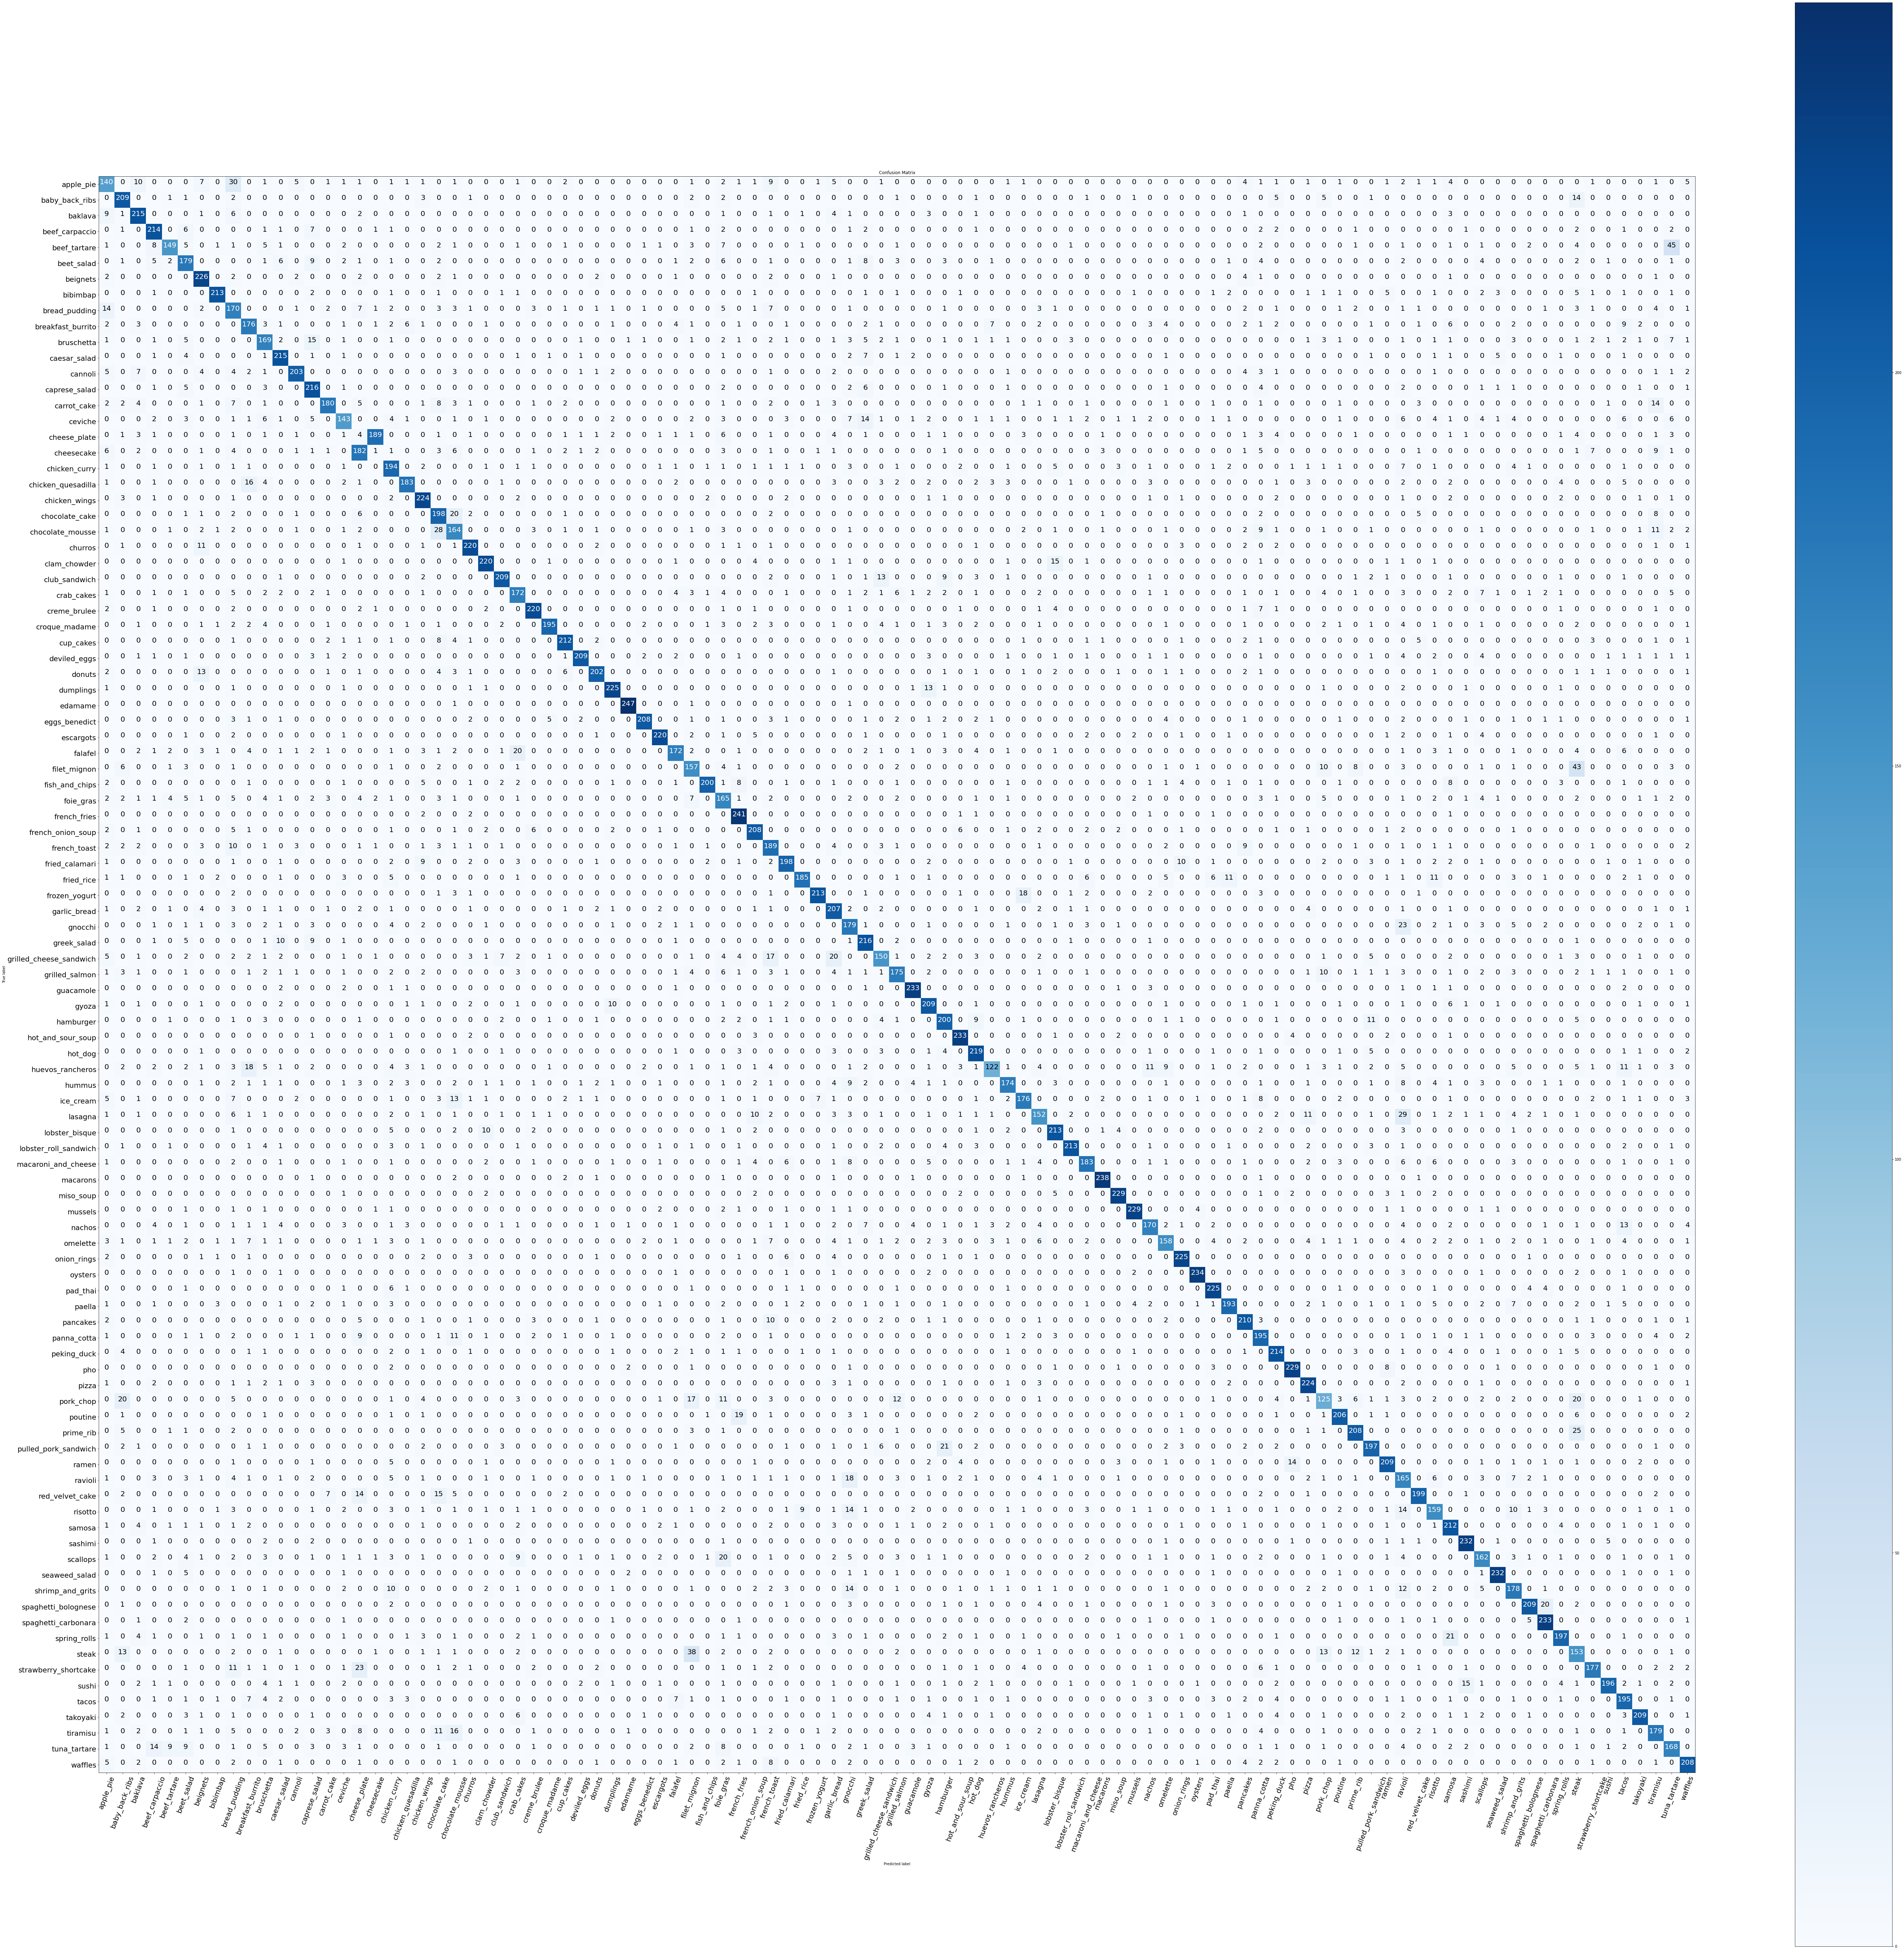

In [9]:
from helperFunctions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes= class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True,
                      rotate=True,
                      norm=False,
                      ax=1) # Set ax to 0 if predictions and labels are 1-dim